# ES7 Solution Sketch

:::{warning}
This is a work in progress - end goal is to get a working model framework, then students modify to fit the problem statement, formulate narrative answers, etc.
:::

:::{note}
Populate this portion with the problem prompt
:::


Model build notes (flow model):
- memory purge script DONE
- problem set up database: IN PROGRESS
- import MF6 FloPy script DONE
- define workspace script DONE
- set simulation name: DONE
- set flow model name: DONE
- set time discretization: DONE
- solver for flow model: DONE
- discretization for flow model: DONE
- initial conditions for flow model: DONE
- node property flow package: DONE
- storage package: DONE
- constant head package: DONE
- well package (if applicable): SKIP TRY 1
- output control for flow model: DONE
- Attempt FLOW model run: SUCCESS; NEED TO CHECK OUTPUTS
- build starting concentration arrays

In [1]:
%reset -f

In [2]:
# purge memory and reset_environment
import sys

def reset_namespace():
    """Delete all user-defined global variables."""
    globs = globals().copy()
    for name in globs:
        if not name.startswith("__") and not isinstance(globs[name], type(sys)):
            del globals()[name]

reset_namespace()

In [3]:
# import packages for modflow6 and flopy
import os
import pathlib as pl
from pprint import pformat
import flopy
#import git
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from flopy.plot.styles import styles
#from modflow_devtools.misc import get_env, timed
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [39]:
#Problem set-up database and simulation control constants

# Console output flags
verbose = True # Used for tree-killing level of output; set to False for production run(s)

# Model units
length_units = "meters"
time_units = "seconds"

# Model grid geometry
nlay = 3  # Number of layers
nrow = 50  # Number of rows
ncol = 26  # Number of columns
# Layer 1 == top, Layer 2== middle, Layer 3 ==bottom
delr = 200.0*(1.0/3.28)  # Column width ($m$)
delc = 200.0*(1.0/3.28)  # Row width ($m$)
delz = [175.0*(1.0/3.28),15.0*(1.0/3.28),60.0*(1.0/3.28)]  # Layer thickness ($m$)
top = 3150.0*(1.0/3.28)  # Top of the model ($m$)
bottom = np.array([2975.0*(1.0/3.28),2960.0*(1.0/3.28),2900.0*(1.0/3.28)]) # layer bottom elevations


# Aquifer hydraulic properties
pors1 = 0.38
pors2 = 0.40
pors3 = 0.35
porosity = [pors1,pors2,pors3]  # Porosity
k1 = 25.0*(1.0/3.28)  # Horiz. hyd. conductivity of top layer ($m/sec$)
k2 = 0.25*(1.0/3.28)  # Horiz. hyd. conductivity of middlelayer ($m/sec$)
k3 = 30.0*(1.0/3.28)  # Horiz. hyd. conductivity of bottom layer ($m/sec$)
hydcon = [k1,k2,k3]
stor1 = 0.20000
stor2 = 0.00040
stor3 = 0.00035
storativity = [stor1,stor2,stor3]

# Simulation layer types
laytyp = icelltype = 0  # this will need modification later on.  laytyp may need to be a list

# Aquifer transport properties
al = 10.0*(1/3.28) # Longitudinal dispersivity ($m$)
at =  1.0*(1/3.28) # Transverse dispersivity ($m$) 
### Assume dispeasuvuty same all layers
trpt = at/al  # Ratio of horiz. transverse to longitudinal dispersivity ($m$)
### If adsorbtion
kd = 0.20
### If 1st order decay
lamb = 1.0


# build porosity array(s)
pors_array = np.ones((nlay, nrow, ncol), dtype=float)
for ilay in range(nlay):
    pors_array[ilay] = porosity[ilay]*pors_array[ilay]
if verbose:
    print("\n porosity array(s)")
    for ilay in range(nlay):
        print(f"\nLayer {ilay + 1}")
        print("-" * (4 + 3 * ncol))  # simple header line
        for irow in range(nrow):
            print(" ".join(f"{val:.2f}" for val in pors_array[ilay, irow, :]))

# build hydraulic conductivity array(s)
hk_array = np.ones((nlay, nrow, ncol), dtype=float)
for ilay in range(nlay):
    hk_array[ilay] = hydcon[ilay]*hk_array[ilay]
if verbose:
    print("\n hydraulic conductivity array(s)")
    for ilay in range(nlay):
        print(f"\nLayer {ilay + 1}")
        print("-" * (4 + 3 * ncol))  # simple header line
        for irow in range(nrow):
            print(" ".join(f"{val:.2f}" for val in hk_array[ilay, irow, :]))

# build storativity array(s)
ss_array = np.ones((nlay, nrow, ncol), dtype=float)
for ilay in range(nlay):
    ss_array[ilay] = storativity[ilay]*ss_array[ilay]
if verbose:
    print("\n storage coefficient array(s)")
    for ilay in range(nlay):
        print(f"\nLayer {ilay + 1}")
        print("-" * (4 + 3 * ncol))  # simple header line
        for irow in range(nrow):
            print(" ".join(f"{val:.4f}" for val in ss_array[ilay, irow, :]))
            
# build computation domain array(s)
idomain = np.ones((nlay, nrow, ncol), dtype=int)  # entire 3d domain
if verbose:
    print("\n computation domain array(s)")
    for ilay in range(nlay):
        print(f"\nLayer {ilay + 1}")
        print("-" * (4 + 3 * ncol))  # simple header line
        for irow in range(nrow):
            print(" ".join(f"{val:3d}" for val in idomain[ilay, irow, :]))

# build boundary array(s) -- assume boundary conditions to all layers
# Boundaries
# Create a 3D array of zeros
ibound = np.zeros((nlay, nrow, ncol), dtype=int) # entire 3d domain
for ilay in range(nlay):
    ibound[ilay, 0, 0:21] = [-1 for i in range(ncol-5)] # top row all -1
    ibound[ilay,-1, 9:] = [-1 for i in range(9,ncol)] # bottom row all -1
    ##########################
    ibound[ilay,1,0]= -1 
    ibound[ilay,2,0]= -1 
    ibound[ilay,3,0]= -1 
    ##########################
    ibound[ilay,-2,-1]= -1 
    ibound[ilay,-3,-1]= -1 
    ibound[ilay,-4,-1]= -1 
    ibound[ilay,-5,-1]= -1 
if verbose:
    print("boundary condition array(s)")
#    print(ibound)
    for ilay in range(nlay):
        print(f"\nLayer {ilay + 1}")
        print("-" * (4 + 3 * ncol))  # simple header line
        for irow in range(nrow):
            print(" ".join(f"{val:3d}" for val in ibound[ilay, irow, :]))

# Build initial conditions array(s)
# Create a 3D array of ones
inithead = (0.5*(3100+3040))*np.ones((nlay, nrow, ncol), dtype=float) # entire 3d domain set to 1.0
for ilay in range(nlay):
    inithead[ilay, 0,:] = [3100.0 for i in range(ncol)] # top row all -1
    inithead[ilay,-1,:] = [3040.0 for i in range(ncol)] # bottom row all -1
    ##########################
    inithead[ilay,1,0]= 3100.0
    inithead[ilay,2,0]= 3100.0 
    inithead[ilay,3,0]= 3100.0
    ##########################
    inithead[ilay,-2,-1]= 3040.0 
    inithead[ilay,-3,-1]= 3040.0 
    inithead[ilay,-4,-1]= 3040.0  
    inithead[ilay,-5,-1]= 3040.0 
if verbose:
    print("initial head condition array(s)")
#    print(ibound)
    for ilay in range(nlay):
        print(f"\nLayer {ilay + 1}")
        print("-" * (4 + 3 * ncol))  # simple header line
        for irow in range(nrow):
            print(" ".join(f"{val:.0f}" for val in inithead[ilay, irow, :]))


# Build starting concentration arrays(s)
sconc = np.zeros((nlay, nrow, ncol), dtype=float) # entire 3d domain set to 0.0
#
for ilay in range(nlay):
    sconc[ilay,6,6:9] = [5.0 for i in range(3)] # 3 columns, row 7
    sconc[ilay,7,5:12] = [5.0 for i in range(7)]
    sconc[ilay,8,5:13] = [5.0 for i in range(8)]
    sconc[ilay,8,6:10] = [100.0 for i in range(4)]
    sconc[ilay,9,5:13] = [5.0 for i in range(8)]
    sconc[ilay,9,6:10] = [100.0 for i in range(4)]
    sconc[ilay,9,10:12] = [10.0 for i in range(2)]
    #
    sconc[ilay,10,5:13] = [5.0 for i in range(8)]
    sconc[ilay,10,6:9] = [500.0 for i in range(3)]
    sconc[ilay,10,9:10] = [100.0 for i in range(1)]
    sconc[ilay,10,10:11] = [50.0 for i in range(1)]
    sconc[ilay,10,11:12] = [10.0 for i in range(1)]
    #
    sconc[ilay,11,5:13] = [5.0 for i in range(8)]
    sconc[ilay,12,5:13] = [5.0 for i in range(8)]
    sconc[ilay,13,5:13] = [5.0 for i in range(8)]
    sconc[ilay,14,5:13] = [5.0 for i in range(8)]
    sconc[ilay,15,5:13] = [5.0 for i in range(8)]
    sconc[ilay,16,6:13] = [5.0 for i in range(7)]
    sconc[ilay,17,7:13] = [5.0 for i in range(6)]
    sconc[ilay,18,8:13] = [5.0 for i in range(5)]
    
if verbose:
    print("initial concentration array(s)")
#    print(ibound)
    for ilay in range(nlay):
        print(f"\nLayer {ilay + 1}")
        print("-" * (4 + 3 * ncol))  # simple header line
        for irow in range(nrow):
            print(" ".join(f"{val:.0f}" for val in sconc[ilay, irow, :]))

# Build dispersivity arrays
al = 10.0*(1/3.28) # Longitudinal dispersivity ($m$)
trpt = 0.1  # Ratio of horiz. transverse to longitudinal dispersivity ($m$)

# Build distribution coefficient arrays
kd_b = 0.20

# Build 1st order decay arrays

decay_lambda = 0.00

# Build time information

# Time variables
perlen = [365.0 * 86400, 365.0 * 86400]
steady = [True, True]
nper = len(perlen)
nstp = [365, 365]
tsmult = [1.0, 1.0]

# Solver settings
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0
percel = 1.0  # HMOC parameters
itrack = 2
wd = 0.5
dceps = 1.0e-5
nplane = 0
npl = 0
nph = 16
npmin = 2
npmax = 32
dchmoc = 1.0e-3
nlsink = nplane
npsink = nph
nadvfd = 1


 porosity array(s)

Layer 1
----------------------------------------------------------------------------------
0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38
0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38
0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38
0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38
0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38
0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38
0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.3

In [5]:
# define workspace and executibles -- THISISMACHINE SPECIFIC
binary = "/home/sensei/mfplayground/modflow-python/mf6.4.1_linux/bin/mf6"  # location on MY computer of the compiled modflow program
directory_name = "es7_soln"
workarea = os.path.join("/home/sensei/ce-5364-webroot/mfexperiments", directory_name)
os.makedirs(workarea, exist_ok=True)

The workflow for the flow model will generally involve the following:
```
###### Instantiating MODFLOW 6 groundwater flow model            ########
###### Instantiating MODFLOW 6 time discretization               ########
###### Instantiating MODFLOW 6 solver for flow model             ########
###### Instantiating MODFLOW 6 discretization for flow model     ########
###### Instantiating MODFLOW 6 initial conditions for flow model ########
###### Instantiating MODFLOW 6 node-property flow package        ########
###### Instantiating MODFLOW 6 storage package                   ########
###### Instantiating MODFLOW 6 constant head package             ########
###### Instantiating MODFLOW 6 well package (if applicable)      ########
###### Instantiating MODFLOW 6 output control for flow model     ########
```
These are created one-by-one in the cells below

In [6]:
# set simulation name(s)
name = "es7"
gwfname = "gwf-" + name
gwtname = "gwt-" + name

##### FLOPY build simulation framework ####
sim = flopy.mf6.MFSimulation(
    sim_name="sim-" + name, exe_name=binary, version="mf6", sim_ws=workarea
)

model_nam_file = f"{gwfname}.nam"

if gwfname in sim.model_dict:
    gwf = sim.get_model(gwfname)
    if verbose:
        print(f"GWF model '{gwfname}' already exists in sim.")
else:
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=model_nam_file,
    )
    if verbose:
        print(f"Created GWF model '{gwfname}' with name file {model_nam_file}")


Created GWF model 'gwf-es7' with name file gwf-es7.nam


In [7]:
###### Instantiating MODFLOW 6 time discretization               ########
tdis_rc = []
for i in range(nper):
    tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
if verbose:
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)
    print("time discritization framework created into object: ""tdis_rc"" ")
else:
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units);

time discritization framework created into object: tdis_rc 


In [8]:
###### Instantiating MODFLOW 6 solver for flow model             ########
# Set Iterative Model Solution (choose solver parameters)
# about IMS see: https://water.usgs.gov/nrp/gwsoftware/ModelMuse/Help/sms_sparse_matrix_solution_pac.htm
# using defaults see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.mf6.modflow.mfims.html
imsgwf = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation="NONE",
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=rclose,
    linear_acceleration="CG",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=relax,
    filename=f"{gwfname}.ims",
    )
if verbose:
    sim.register_ims_package(imsgwf, [gwf.name])
    print(f"solver framework created into object: {gwfname}.ims ")
else:
    sim.register_ims_package(imsgwf, [gwf.name]);   

solver framework created into object: gwf-es7.ims 


In [9]:
###### Instantiating MODFLOW 6 discretization for flow model     ########
if verbose:
    flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=bottom,
    idomain=idomain,
    filename=f"{gwfname}.dis",
    )
    print(f"grid framework created into object: {gwfname}.dis ")
else:
    flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=bottom,
    idomain=idomain,
    filename=f"{gwfname}.dis",
    );


grid framework created into object: gwf-es7.dis 


In [10]:
###### Instantiating MODFLOW 6 initial conditions for flow model ########
if verbose:
    flopy.mf6.ModflowGwfic(gwf, strt=inithead, filename=f"{gwfname}.ic")
    print(f"initial heads framework created into object: {gwfname}.ic ")
else:
    flopy.mf6.ModflowGwfic(gwf, strt=inithead, filename=f"{gwfname}.ic");

initial heads framework created into object: gwf-es7.ic 


In [11]:
###### Instantiating MODFLOW 6 node-property flow package        ########
if verbose:
    flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=False,
    icelltype=icelltype,
    k=hk_array,
    k33=hk_array,
    save_specific_discharge=True,
    filename=f"{gwfname}.npf",
    )
    print(f"node-property framework created into object: {gwfname}.npf ")
else:
    flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=False,
    icelltype=icelltype,
    k=hk_array,
    k33=hk_array,
    save_specific_discharge=True,
    filename=f"{gwfname}.npf",
    );

node-property framework created into object: gwf-es7.npf 


In [12]:
###### Instantiating MODFLOW 6 storage package                   ########
if verbose:
    sto = flopy.mf6.ModflowGwfsto(gwf,storagecoefficient=True, ss=ss_array)
    print("storage framework created into object: ""sto"" ")
else:
    sto = flopy.mf6.ModflowGwfsto(gwf,storagecoefficient=True, ss=ss_array);
## delete ";" in above line at end to show full output

########## Does storage need multi-period

storage framework created into object: sto 


In [13]:
### NEED FIX MULTIPLE STRESS PERIODS HERE ###
###### Instantiating MODFLOW 6 constant head package             ########
if verbose:
    chdspd = []
    for ilay in range(nlay):
        for irow in range(nrow):
            for jcol in range(ncol):
                if ibound[ilay,irow,jcol]==-1 and irow <= 6:
                    chdspd.append([(ilay, irow, jcol), 3100.0, 0.0]) # set head and concentration
                if ibound[ilay,irow,jcol]==-1 and irow >= 44:
                    chdspd.append([(ilay, irow, jcol), 3040.0, 0.0]) # set head and concentration              
    flopy.mf6.ModflowGwfchd(
    gwf,
    maxbound=len(chdspd),
    stress_period_data=chdspd,
    save_flows=False,
    auxiliary="CONCENTRATION",
    pname="CHD-1",
    filename=f"{gwfname}.chd",
    )
    print(f"constant head framework created into object: {gwfname}.chd ")
else:
    chdspd = []
    for ilay in range(nlay):
        for irow in range(nrow):
            for jcol in range(ncol):
                if ibound[ilay,irow,jcol]==-1 and irow <= 6:
                    chdspd.append([(ilay, irow, jcol), 3100.0, 0.0]) # set head and concentration
                if ibound[ilay,irow,jcol]==-1 and irow >= 44:
                    chdspd.append([(ilay, irow, jcol), 3040.0, 0.0]) # set head and concentration              
    flopy.mf6.ModflowGwfchd(
    gwf,
    maxbound=len(chdspd),
    stress_period_data=chdspd, #<<<<<<<<<<<<<<<<<<<<<<<< HERE
    save_flows=False,
    auxiliary="CONCENTRATION",
    pname="CHD-1",
    filename=f"{gwfname}.chd",
    );
## delete ";" in above line at end to show full output

constant head framework created into object: gwf-es7.chd 


In [14]:
###### Instantiating MODFLOW 6 well package (if applicable)      ########
if verbose:
    print("no wells this simulation")
else:
    pass

no wells this simulation


In [15]:
###### Instantiating MODFLOW 6 output control for flow model     ########
if verbose:
    flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{gwfname}.hds",
    budget_filerecord=f"{gwfname}.bud",
    headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )
    print(f"output control for flow model created into objects {gwfname}.hds and {gwfname}.bud ")
else:
    flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{gwfname}.hds",
    budget_filerecord=f"{gwfname}.bud",
    headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    );

output control for flow model created into objects gwf-es7.hds and gwf-es7.bud 


In [16]:
# Write files to the directory - FLOW MODEL ONLY
if verbose:
    sim.write_simulation()
else:
    sim.write_simulation();

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model gwf-es7...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package chd-1...
    writing package oc...


In [17]:
# Attempt to run MODFLOW this model
if verbose:
    silent = False
else:
    silent = True

success, buff = sim.run_simulation(silent=silent, report=True)

if success:
    print("\033[1;32mMODFLOW 6 normal termination.\033[0m")   # bold green
else:
    print("\033[1;31mMODFLOW 6 did NOT terminate normally!\033[0m")  # bold red
    raise Exception("MODFLOW 6 did not terminate normally.")

FloPy is using the following executable to run the model: ../../../mfplayground/modflow-python/mf6.4.1_linux/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/10/2025

   MODFLOW 6 compiled Feb 14 2025 13:39:18 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neithe

## Flow Model – Post-Processing and Hydraulic Reasonableness Check

Before moving on to transport modeling, it is essential to verify that the groundwater flow solution behaves in a physically reasonable way. In this section, we will visualize the simulated hydraulic head distribution in all three layers for both the initial and final times of the steady-state run (recall that for steady flow, these should be identical unless transient storage was activated).

The goal here is not yet to interpret plume behavior or evaluate well impacts.
Instead, we are performing a sanity check on the model’s hydraulics:

Do heads decrease in the expected down-gradient direction?

Are vertical gradients consistent with the conceptual hydrogeologic system (unconfined → aquitard → leaky confined)?

Do pumping wells induce appropriate drawdowns in the correct layers?

Are boundary conditions behaving as intended (constant head, no-flow, or others)?

Is the system numerically stable (no oscillations, unreasonable values, or artifacts)?

If the hydraulic field is incorrect, any subsequent GWT transport simulation will also be incorrect—since advective velocities and flow exchanges come directly from this flow solution.

For now, we will generate plots of heads in Layer 1, Layer 2, and Layer 3.
Later, once the hydraulics are validated, we may choose to suppress or streamline these plots to focus on the actual transport problems in Exercise Set 7.

In [18]:
hobj = gwf.output.head()

print("=== Head file explorer ===")
print("kstp,kper combos:", hobj.get_kstpkper())
print("Times:", hobj.get_times())

# Get last timestep by default
h = hobj.get_data()
print("Head array shape:", h.shape)
print("Layer count:", h.shape[0])

for k in range(h.shape[0]):
    print(f"Layer {k+1}: min={h[k].min():.3f}, max={h[k].max():.3f}")


=== Head file explorer ===
kstp,kper combos: [(np.int32(364), np.int32(0)), (np.int32(364), np.int32(1))]
Times: [np.float64(31536000.0), np.float64(63072000.0)]
Head array shape: (3, 50, 26)
Layer count: 3
Layer 1: min=3040.000, max=3100.000
Layer 2: min=3040.000, max=3100.000
Layer 3: min=3040.000, max=3100.000


[[3100.         3100.         3100.         ... 3095.59477136
  3095.09710538 3094.86207994]
 [3100.         3099.64965221 3099.3843541  ... 3095.26110073
  3094.83446485 3094.62705449]
 [3100.         3099.21425474 3098.68465866 ... 3094.68765165
  3094.35259881 3094.18461867]
 ...
 [3050.19104234 3050.07121793 3049.82903907 ... 3041.1670703
  3040.6456397  3040.        ]
 [3049.92866444 3049.7999369  3049.53850154 ... 3040.55515421
  3040.30019848 3040.        ]
 [3049.79501407 3049.66136371 3049.38914014 ... 3040.
  3040.         3040.        ]]
3100.0


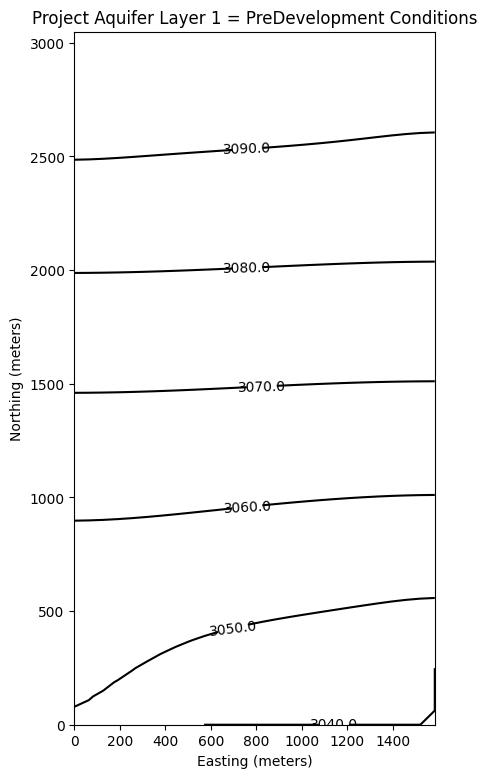

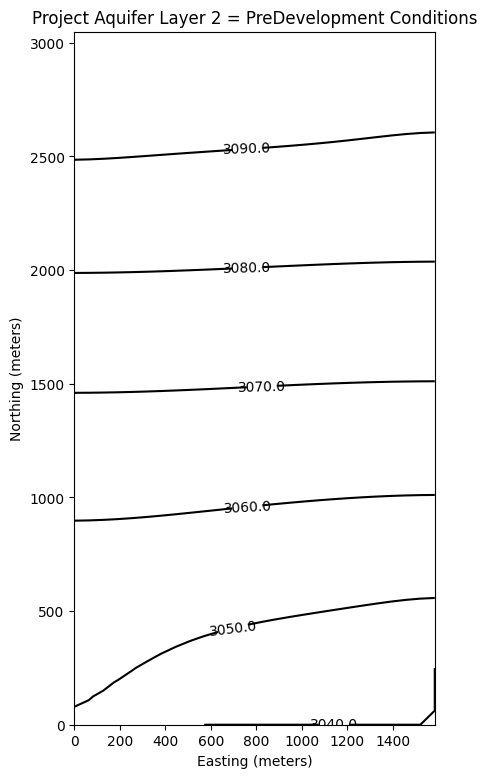

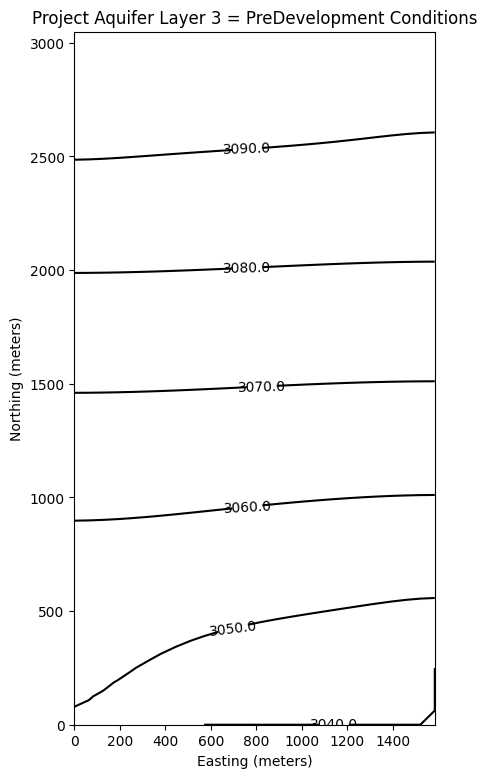

In [19]:
## now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(364, 0))
print(h[0])
x =  np.linspace(0, delc*ncol, ncol)
y =  np.linspace(0, delr*nrow, nrow)
y = y[::-1]
vmin, vmax = 2900.0, 3210.0
contour_intervals = np.arange(2900.0, 3210.0, 10.0)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 1 = PreDevelopment Conditions")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

# ### Plot a Map of Layer 2

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[1], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 2 = PreDevelopment Conditions")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

# ### Plot a Map of Layer 3

print(h[2].max())

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[2], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 3 = PreDevelopment Conditions")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

Now build the transport model parts

In [20]:
###### Instantiating MODFLOW 6 groundwater transport model (GWT) ######
gwt_nam_file = f"{gwtname}.nam" # gwt is defined in the initial simulation build block

if gwtname in sim.model_dict:
    gwt = sim.get_model(gwtname)
    if verbose:
        print(f"GWT model '{gwtname}' already exists in sim.")
        print(f"Name file:", gwt.name_file.filename)
else:
    gwt = flopy.mf6.ModflowGwt(
        sim,
        modelname=gwtname,
        save_flows=True,
        model_nam_file=gwt_nam_file,
    )
    if verbose:
        print(f"Created GWT model '{gwtname}' with name file {gwt_nam_file}")


Created GWT model 'gwt-es7' with name file gwt-es7.nam


In [21]:
# create iterative model solution and register the gwt model with it
imsgwt = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation="NONE",
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=rclose,
    linear_acceleration="BICGSTAB",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=relax,
    filename=f"{gwtname}.ims",
    )


if verbose:
    sim.register_ims_package(imsgwf, [gwt.name])
    print(f"transport solver framework created into object: {gwtname}.ims ")
else:
    sim.register_ims_package(imsgwf, [gwt.name]);   

transport solver framework created into object: gwt-es7.ims 


In [22]:
###### Instantiating MODFLOW 6 discretization for transport model     ########
if verbose:
    flopy.mf6.ModflowGwtdis(
    gwt,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=bottom,
    idomain=idomain,
    filename=f"{gwtname}.dis",
    )
    print(f"transport grid framework created into object: {gwtname}.dis ")
else:
    flopy.mf6.ModflowGwtdis(
    gwt,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=bottom,
    idomain=idomain,
    filename=f"{gwtname}.dis",
    );
# Observe subtle name differences in both the name "gwt" and the API function call: flopy.mf6.ModflowGwtdis""

transport grid framework created into object: gwt-es7.dis 


In [ ]:
# Instantiating MODFLOW 6 transport initial concentrations
flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic");
## delete ";" in above line at end to show full output